In [1]:
import sys, os

sys.path.append('../lib/')
sys.path.append('../sim_lib/')

def ospath(paths):
    if ('win32' in sys.platform):
        if type(paths)==list or type(paths)==tuple:
            paths = [fn.replace('/c/','c:\\').replace('/', '\\') for fn in paths]
        else:
            paths = paths.replace('/c/','c:\\').replace('/', '\\')
    return paths

import numpy as np

import logging
logger = logging.getLogger('stochastic_ir')
hdlr = logging.FileHandler('./stochastic_ir.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

from  matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import datetime
import copy
import pickle


%matplotlib inline

In [2]:
from scipy.stats import norm
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import scipy.interpolate

In [3]:
import json
import calibrator
import interpolator
import surfaces

# Read Implied Vol, correlations, EUR and USD DF curves

In [4]:
MARKETDATA = '../marketdata_JSON_asof_04_30_2020/'
with open(MARKETDATA+'EUR.json', 'r') as f:
    eurdata = json.load(f)
with open(MARKETDATA+'USD.json', 'r') as f:
    usddata = json.load(f)
with open(MARKETDATA+'EURUSD.json', 'r') as f:
    eurusddata = json.load(f)
with open(MARKETDATA+'correlations.json', 'r') as f:
    correlations = json.load(f)

In [5]:
rho_domestic_base = correlations['USD_EUR']
rho_base_fx = correlations['EUR_EURUSD']
rho_domestic_fx = correlations['USD_EURUSD']

base_ta = eurdata['g1++']['meanrev']['times']
base_a = eurdata['g1++']['meanrev']['values']
base_tvol = eurdata['g1++']['vol']['times']
base_vol = eurdata['g1++']['vol']['values']
base_x0 = eurdata['g1++']['x0']
base_shifttimes = eurdata['g1++']['shift']['times']
base_shiftvalues = eurdata['g1++']['shift']['values']

domestic_ta = usddata['g1++']['meanrev']['times']
domestic_a = usddata['g1++']['meanrev']['values']
domestic_tvol = usddata['g1++']['vol']['times']
domestic_vol = usddata['g1++']['vol']['values']
domestic_x0 = usddata['g1++']['x0']
domestic_shifttimes = usddata['g1++']['shift']['times']
domestic_shiftvalues = usddata['g1++']['shift']['values']

fxvoldata = eurusddata['impliedvol']
spot_FX = eurusddata['spot']

base_dfcurve = interpolator.InterpolatedCurve(eurdata['discount']['times'], 
                                              eurdata['discount']['values'])
dfcurve = interpolator.InterpolatedCurve(usddata['discount']['times'], 
                                         usddata['discount']['values'])

In [6]:
fxvoldata = eurusddata['impliedvol']
spot_FX = eurusddata['spot']

In [7]:
base_dfcurve = interpolator.InterpolatedCurve(eurdata['discount']['times'], 
                                              eurdata['discount']['values'])
dfcurve = interpolator.InterpolatedCurve(usddata['discount']['times'], 
                                         usddata['discount']['values'])

In [8]:
correlations

{'USD_EUR': 0.161,
 'USD_EURUSD': 0.166,
 'EUR_EURUSD': 0.551,
 'USD_EURUSDstochvar': -0.2,
 'EUR_EURUSDstochvar': -0.2,
 'EURUSD_EURUSDstochvar': -0.3620005301106583}

In [9]:
with open(MARKETDATA+'EURUSD_Heston.json', 'r') as f:
    hestondata = json.load(f)
    
heston_kappa_dict = hestondata['kappa']
heston_volofvar_dict = hestondata['volofvar']
heston_theta_dict = hestondata['theta']
heston_initialvar = hestondata['initialvar']

In [10]:
rho_fx_v = hestondata['rho'] 
rho_domestic_v = correlations['USD_EURUSDstochvar']
rho_base_v = correlations['EUR_EURUSDstochvar']

# Interpolate Implied Vol

In [11]:
import fxivolinterpolator as fxvol

In [12]:
fxvolsurf = fxvol.FXIVolInterpolator(eurusddata['impliedvol'], 
                                     eurusddata['spot'], dfcurve, base_dfcurve)

# Setup calibration local vol spots and times

In [13]:
import StochasticSim_Multiprocessing as simulator

In [14]:
if 'locvol_sim' in locals() or 'locvol_sim' in globals():
    locvol_sim.delete_all()
    del(locvol_sim)
    print('Deleted lvolsim')

In [15]:
base_shortratecrv = interpolator.constructShortRateCurve(base_dfcurve)
domestic_shortratecrv = interpolator.constructShortRateCurve(dfcurve)

In [16]:
nr_mcruns = 100000 ### number of calibration runs
NRSUBSIM = 5  ### number of multiprocessing sub-processes 
LVOL_NUMMETHOD = 'ForwardEuler'
SHORTRATE_NUMMETHOD = 'ForwardEuler'
ANTITHETIC = True #False #

locvol_sim = simulator.StochasticLocalVolSimulation(
                domestic_shortratecrv.times, domestic_shortratecrv.values, 
                base_shortratecrv.times, base_shortratecrv.values, spot_FX,
                heston_initialvar, heston_volofvar_dict, 
                heston_kappa_dict, heston_theta_dict,
                domestic_ta, domestic_a, domestic_tvol, domestic_vol, domestic_x0,
                base_ta, base_a, base_tvol, base_vol, base_x0,
                rho_domestic_base, rho_domestic_fx, rho_base_fx,
                rho_fx_v, rho_domestic_v, rho_base_v,
                nr_mcruns, LVOL_NUMMETHOD, SHORTRATE_NUMMETHOD,
                antitheticpaths=ANTITHETIC,
                in_forward_measure=True,
                nrsubsim=NRSUBSIM,
                observation_names=['FXrate', 'FXStochVariance'], 
                observe_at_given_times=True,
                domestic_currency_name='USD',
                base_currency_name='EUR',
                fx_name='EURUSD',
                )

Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Initializing pool for ... <class 'StochasticSim_Multiprocessing.StochasticLocalVolSimulation'>


# Read Current Localvol

In [17]:
def get_unique_from_sorted_array(arrvals, tolerance=1e-6):
    #tolerance = 1e-6
    idxmask = (arrvals[1:] - arrvals[:-1])<tolerance
    return arrvals[:-1][~idxmask]

IS_LOCVOL_RECTANGULAR=False
IMPLIEDVOL_NRY_FX = 100

LOCALVOL_CAP = 1.0

IMPLIEDVOL_TIMES_FX = np.array(sorted(fxvolsurf.times + [0.025] + list(np.arange(0.05, 1.00, 0.05))))
IMPLIEDVOL_TIMES_FX = get_unique_from_sorted_array(IMPLIEDVOL_TIMES_FX)

LOCALVOL_NRSPOTS_FX = 100
LOCALVOL_TIMES_FX = [0.025] + list(np.arange(0.05, 1.00, 0.05))  


In [18]:
surface = surfaces.generate_tiv_surface_nonuniform(
            fxvolsurf, IMPLIEDVOL_NRY_FX, IMPLIEDVOL_TIMES_FX, #gxldata.fxvolsurface
            dfcurve, base_dfcurve, spot_FX,
            localvol_cap=LOCALVOL_CAP, width_nr_stdev=3.6)

Creating implied total variance interpolator
Created implied total variance interpolator


In [19]:
lvol_file_nmc=nr_mcruns

L_FILENAME = 'leverage_sampleFULL_%d.pkl' % (lvol_file_nmc)
OUTPUTDIR = './output_SLV_2DIR/'

In [20]:
VAR_METHOD = 'binning' #'curve_fit' #
locvol_cal = calibrator.StochasticLocalVolDeterministicIRCalibration(
                surface, locvol_sim,
                var_method=VAR_METHOD,
                filename=ospath(OUTPUTDIR + L_FILENAME))

In [21]:
strike_grid = surfaces.generate_2d_strike_grid(surface, 
                                               LOCALVOL_NRSPOTS_FX, 
                                               LOCALVOL_TIMES_FX, 
                                               IS_LOCVOL_RECTANGULAR)

In [22]:
l_values = locvol_cal.calibrate_localvol(strike_grid, LOCALVOL_TIMES_FX)

Processing time: 0.025000
ProcessID:0, n_trials:20000, maturity:0.025, timesteps:6
ProcessID:1, n_trials:20000, maturity:0.025, timesteps:6
ProcessID:2, n_trials:20000, maturity:0.025, timesteps:6
ProcessID:3, n_trials:20000, maturity:0.025, timesteps:6
ProcessID:4, n_trials:20000, maturity:0.025, timesteps:6
Reading X and U at step  7
Written: .\output_SLV_2DIR\leverage_sampleFULL_100000.pkl
Processing time: 0.050000
ProcessID:0, n_trials:20000, maturity:0.050, timesteps:12
ProcessID:1, n_trials:20000, maturity:0.050, timesteps:12
ProcessID:2, n_trials:20000, maturity:0.050, timesteps:12
ProcessID:3, n_trials:20000, maturity:0.050, timesteps:12
ProcessID:4, n_trials:20000, maturity:0.050, timesteps:12
Reading X and U at step  13
Written: .\output_SLV_2DIR\leverage_sampleFULL_100000.pkl
Processing time: 0.100000
ProcessID:0, n_trials:20000, maturity:0.100, timesteps:25
ProcessID:1, n_trials:20000, maturity:0.100, timesteps:25
ProcessID:2, n_trials:20000, maturity:0.100, timesteps:25
Pr

In [23]:
l_data = {}
l_data['spots'] = strike_grid
l_data['times'] = LOCALVOL_TIMES_FX
l_data['surfacevalues'] = l_values[1:]

In [24]:
FILENAME = 'leverage_data%d.pkl'%nr_mcruns

with open(OUTPUTDIR+FILENAME, 'wb') as f:
    pickle.dump(l_data, f)

In [25]:
len(l_data['spots']), len(l_data['times']), len(l_data['surfacevalues'])

(20, 20, 20)

(19, 100) (19, 100) (19, 100)


Text(0.5, 0.92, 'Local Vol surface')

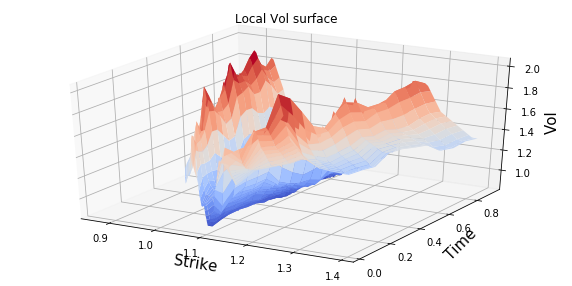

In [26]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_lvol = np.array(l_data['spots'][:num_slices]) 
Y_lvol = np.array([l_data['times'][:num_slices]]*X_lvol.shape[1]).T
Z_lvol = np.array(l_data['surfacevalues'][:num_slices])
print(X_lvol.shape, Y_lvol.shape, Z_lvol.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d') 
surf = ax.plot_surface(X_lvol, Y_lvol, Z_lvol, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Vol', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([-0.05, 0.13])
ax.set_title('Local Vol surface')